Notes: 
* [Qiskit Nature tutorials](https://qiskit.org/documentation/nature/tutorials/index.html)
* [IBM Challenges](https://github.com/search?q=org%3Aqiskit-community+challenge)
* [2022 Spring Challenge - tight binding](https://github.com/qiskit-community/ibm-quantum-spring-challenge-2022/blob/main/exercise1/01.CM_trotterization.ipynb)
* [2021 IBM Quantum Simulation challenge](https://github.com/qiskit-community/open-science-prize-2021/blob/main/ibmq-qsim-challenge.ipynb)
* [2018 community tutorial ising model time simulation](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/exact_ising_model_simulation/Ising_time_evolution.ipynb)

In [1]:
from qiskit import *
from typing import TypedDict


In [22]:
from qiskit import *
from typing import TypedDict

import pandas as pd 
from qiskit.quantum_info import SparsePauliOp
from qiskit.result import sampled_expectation_value, Counts
from typing import Union, List, Dict

class CountsProcess:
    
    @classmethod 
    def pauli_exp_val_all1Q_for_counts(cls, counts:Union[List[Counts], Counts], nolabels=False):
        """ Pauli expectaitoin value for all isngle qubit Z observables across all counts.
            - Simplest version
            - Not very efficient
        Returns:
            - <Z> for qubit Q0...Qn-1 with ordering qubit index is array index.
            - Pauli labels returened are in rightmost is Q0 (qiskit convention)
              To put ot physics notation when in df columns: 
                    df.columns = list(map(lambda x: x[::-1],df.columns))
            """
        if isinstance(counts, Counts):
            nq = counts.creg_sizes[0][1]
            expects = [] if nolabels else {}
            for n in range(nq):
                # In the string representation qubit-0 corresponds to the right-most Pauli character
                pauli = SparsePauliOp.from_sparse_list([("Z", [n], 1)], nq)
                expect = sampled_expectation_value(counts, pauli)
                if nolabels:
                    expects += [expect]
                else:
                    expects[pauli.paulis.to_labels()[0]] = expect
            return expects
        elif isinstance(counts, list):
            expects = []
            for count in counts:
                expect = cls.pauli_exp_val_all1Q_for_counts(count)
                expects += [expect]
            return expects
        
    @classmethod 
    def pauli_exp_val_all2Q_for_counts(cls, counts:Union[List[Counts], Counts], nolabels=False):
        """ Pauli expectaitoin value for all isngle qubit Z observables across all counts.
            - Simplest version
            - Not very efficient
        Returns:
            - <Z> for qubit Q0...Qn-1 with ordering qubit index is array index.
            - Pauli labels returened are in rightmost is Q0 (qiskit convention)
              To put ot physics notation when in df columns: 
                    df.columns = list(map(lambda x: x[::-1],df.columns))
            """
        if isinstance(counts, Counts):
            nq = counts.creg_sizes[0][1]
            expects = [] if nolabels else {}
            for n in range(nq):
                for m in range(n+1, nq):
                    # In the string representation qubit-0 corresponds to the right-most Pauli character
                    pauli = SparsePauliOp.from_sparse_list([("ZZ", [n,m], 1)], nq)
                    expect = sampled_expectation_value(counts, pauli)
                    if nolabels:
                        expects += [expect]
                    else:
                        expects[pauli.paulis.to_labels()[0]] = expect
            return expects
        elif isinstance(counts, list):
            expects = []
            for count in counts:
                expect = cls.pauli_exp_val_all2Q_for_counts(count)
                expects += [expect]
            return expects
            

class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = 4
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)
            
        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2
            
        def config_10q_paper(self):
            self['h'] = 1
            self['J'] = 0.5236
            self['dt'] = 1/4
            
        
    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
            
        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()
        
    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qc = QuantumCircuit(ops['nq'])
        allq = list(range(ops['nq']))
        
        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)
            
        if ops['measure_basis'] == 'Z':
            pass
        elif  ops['measure_basis'] == 'X':
            qc.h(allq)
        elif  ops['measure_basis'] == 'Y':
            qc.sdg(allq)
            qc.h(allq)
        else:
            raise Exception("Must be X Y or Z")
        qc.measure_all()
        
        return qc

    @classmethod
    def make_circs_sweep(cls, ops, sweep_steps = None, measure_bases = None):
        sweep_steps = sweep_steps or [16]
        measure_bases = measure_bases or ['Z']

        circs = []
        run_params = []
        for basis in measure_bases:
            for depth in range(*sweep_steps):
                ops['measure_basis'] = basis
                ops['depth'] = depth
                qc = cls.make_quantum_circuit(ops)
                qc.metadata = {}
                qc.metadata['measure_basis'] = basis
                qc.metadata['depth'] = depth
                run_params += [qc.metadata.copy()]
                circs += [qc]
        return circs, run_params

In [23]:
cls = IsingModel
ops = cls.Options()
ops.config_4q_paper()
# ops.config_10q_paper()
circs, run_params = cls.make_circs_sweep(ops, measure_bases=['Z', 'Y'])
circs[2].draw(fold=-1)

┌───────┐ ░                         ░                         ░ ┌───────┐ ░                         ░                         ░  ░ ┌─┐         
   q_0: ┤ Rx(1) ├─░───■─────────────────■───░─────────────────────────░─┤ Rx(1) ├─░───■─────────────────■───░─────────────────────────░──░─┤M├─────────
        ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░                         ░ ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░                         ░  ░ └╥┘┌─┐      
   q_1: ┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░───■─────────────────■───░─┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░───■─────────────────■───░──░──╫─┤M├──────
        ├───────┤ ░ └───┘└───────────┘└───┘ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ ├───────┤ ░ └───┘└───────────┘└───┘ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░  ░  ║ └╥┘┌─┐   
   q_2: ┤ Rx(1) ├─░───■─────────────────■───░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─┤ Rx(1) ├─░───■─────────────────■───░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░──░──╫──╫─┤M├───
        ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ └───┘└───────────┘└───┘ ░ ├───────┤ ░ ┌─┴─┐┌───────────┐┌─┴─┐ ░ └───┘└───────────┘└───┘ ░  ░  ║  ║ └╥┘┌─┐
   q_3: ┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─────────────────────────░─┤ Rx(1) ├─░─┤ X ├┤ Rz(-0.15) ├┤ X ├─░─────────────────────────░──░──╫──╫──╫─┤M├
        └───────┘ ░ └───┘└───────────┘└───┘ ░                         ░ └───────┘ ░ └───┘└───────────┘└───┘ ░                         ░  ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                            0  1  2  3

In [24]:
backend = Aer.get_backend('aer_simulator')
job = backend.run(circs, shots =1024*3)
print(job.job_id())
job_result = job.result()
all_counts = job_result.get_counts()

5d027103-ca37-415c-9b43-6e51b36e52e4


In [25]:
exp_vals = CountsProcess.pauli_exp_val_all1Q_for_counts(all_counts)
df = pd.DataFrame(exp_vals)
df.columns = list(map(lambda x: x[::-1],df.columns))
df = pd.concat([df, pd.DataFrame(run_params)], axis=1)
df = df.set_index('depth')
df

,ZIII,IZII,IIZI,IIIZ,measure_basis
depth,,,,,
0,1.000000,1.000000,1.000000,1.000000,Z
1,0.548177,0.537760,0.527995,0.547526,Z
2,-0.411458,-0.406250,-0.363281,-0.416667,Z
3,-0.964844,-0.942708,-0.939453,-0.962240,Z
4,-0.645182,-0.581380,-0.604818,-0.644531,Z
5,0.235677,0.241536,0.233724,0.263021,Z
6,0.865234,0.783854,0.779948,0.866536,Z
7,0.664062,0.591797,0.599609,0.665365,Z
8,-0.114583,-0.055990,-0.052734,-0.123698,Z


<Axes: xlabel='depth'>

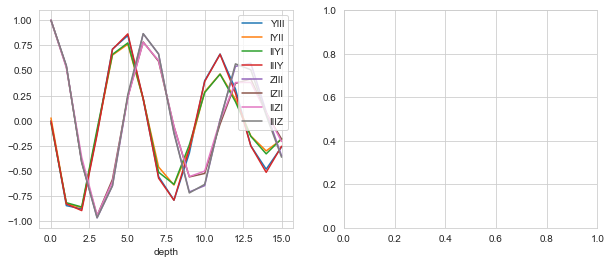

In [27]:
import matplotlib.pyplot as plt
Ys = df.query('measure_basis=="Y"').drop('measure_basis', axis=1)
Zs = df.query('measure_basis=="Z"').drop('measure_basis', axis=1)
Y = Ys.mean(axis=1)
Z = Zs.mean(axis=1)

fig, axs = plt.subplots(1,2,figsize=(10,4))

ax = axs[0]
Ys1 = Ys.copy()
Ys1.columns = list(map(lambda x: x.replace('Z','Y'), Ys.columns))
Ys1.plot(ax=ax)
Zs.plot(ax=ax)

# ax = axs[1]
# ax.plot(Y, Z, marker='o')
# ax.set_aspect(1)
# ax.set_ylim([-1,1])
# ax.set_xlim([-1,1])
# circ = plt.Circle((0,0), 1, fill = False, color='gray', zorder=-1)
# ax.add_artist(circ)
# for n in range(1,5):
#     circ = plt.Circle((0,0), n*0.2, fill = False, color='gray', lw=0.5, linestyle='--', zorder=-1)
#     ax.add_artist(circ)
# ax.grid()
# ax.set_xlabel('<Y>')
# ax.set_ylabel('<Z>')

In [12]:
exp_vals = CountsProcess.pauli_exp_val_all2Q_for_counts(all_counts)
df = pd.DataFrame(exp_vals)
df.columns = list(map(lambda x: x[::-1],df.columns))
df = pd.concat([df, pd.DataFrame(run_params)], axis=1)
df = df.set_index('depth')
df

NameError: name 'all_counts' is not defined

In [11]:
import matplotlib.pyplot as plt
Ys = df.query('measure_basis=="Y"').drop('measure_basis', axis=1)
Zs = df.query('measure_basis=="Z"').drop('measure_basis', axis=1)
Y = Ys.mean(axis=1)
Z = Zs.mean(axis=1)

fig, axs = plt.subplots(1,2,figsize=(10,4))

ax = axs[0]
Ys1 = Ys.copy()
Ys1.columns = list(map(lambda x: x.replace('Z','Y'), Ys.columns))
Ys1.plot(ax=ax)
Zs.plot(ax=ax)

ax = axs[1]
ax.plot(Y, Z, marker='o')
ax.set_aspect(1)
ax.set_ylim([-1,1])
ax.set_xlim([-1,1])
circ = plt.Circle((0,0), 1, fill = False, color='gray', zorder=-1)
ax.add_artist(circ)
for n in range(1,5):
    circ = plt.Circle((0,0), n*0.2, fill = False, color='gray', lw=0.5, linestyle='--', zorder=-1)
    ax.add_artist(circ)
ax.grid()
ax.set_xlabel('<YY>')
ax.set_ylabel('<ZZ>')

NameError: name 'df' is not defined